# Estimation of the sample covariance matrix from compressive measurements

### Project by Abhijat Bharadwaj (210020002) and Animesh Kumar (21d070012)

In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from scipy.io import mmread
import cv2
import time

## MNIST Dataset
source: https://keras.io/api/datasets/mnist/

In [2]:
def mnist_zeros_loader(x1=0,x2=28,y1=0,y2=28,n1=0,n2=6903):
    # Load MNIST dataset
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Filter out only the samples with label 0
    X_train_zeros = X_train[y_train == 0]
    X_test_zeros = X_test[y_test == 0]
    X = np.concatenate((X_train_zeros, X_test_zeros), axis=0)[n1:n2, y1:y2, x1:x2]
    X = X.reshape(-1 , (x2-x1)*(y2-y1)) / 255.0
    X=X.T
    print("Shape of X:", X.shape)
    
    return X
X = mnist_zeros_loader()


Shape of X: (784, 6903)


## Gen4 Matrix Dataset
source: https://www.cise.ufl.edu/research/sparse/matrices/Meszaros/gen4.html

In [3]:
def gen4_loader(p1=0, p2=1537,n1=0,n2=4892):
    # Load the gen4 dataset
    X = mmread("./datasets/gen4.mtx").tocsc() 
    X = X.toarray()
    if(p1!=0 or p2!=1537 or n1!=0 or n2!=4892):
        X= X[p1:p2, n1:n2]
    print("Shape of X:", X.shape)
    return X

gen4_loader()

Shape of X: (1537, 4298)


array([[ 0.        ,  0.36457422,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.63541615,  0.09375179, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.72900391, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.07270836,  0.        , ...,  0.        ,
        -1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -1.        ],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.        ,  1.        ]])

## Traffic Video Dataset

source: https://www.kaggle.com/datasets/aryashah2k/highway-traffic-videos-dataset?select=video

In [4]:
def traffic_loader(x1=0,x2=320,y1=0,y2=240, n1=0, n2=1046):
    X = []
    for i in range(1,21):
        vid = cv2.VideoCapture(f'./datasets/traffic/traffic ({i}).avi')
        while True:
            ret, frame = vid.read()
            if not ret:
                break
            frame = frame[y1:y2,x1:x2]
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # print(gray_frame.shape)
            vectorized = np.array(gray_frame.flatten())
            vectorized = vectorized - np.mean(vectorized)
            # print(vectorized.shape)
            X.append(vectorized)
    X = np.array(X)[n1:n2].T
    print(X.shape)
    return X

traffic_loader()
    

(76800, 1046)


array([[  42.32201823,  103.69730469,  103.57789063, ...,  109.41783854,
         109.3968099 ,  109.3968099 ],
       [  42.32201823,  103.69730469,  103.57789063, ...,  109.41783854,
         109.3968099 ,  109.3968099 ],
       [  43.32201823,  103.69730469,  103.57789063, ...,  109.41783854,
         109.3968099 ,  109.3968099 ],
       ...,
       [-124.67798177, -129.30269531, -129.42210937, ..., -115.58216146,
        -119.6031901 , -119.6031901 ],
       [-122.67798177, -129.30269531, -129.42210937, ..., -113.58216146,
        -120.6031901 , -113.6031901 ],
       [-122.67798177, -129.30269531, -129.42210937, ..., -117.58216146,
        -116.6031901 , -113.6031901 ]])

## Covariance Matrix Estimator

### Biased Estimator
$$\mathbf{\hat{C} }_n = \frac{1}{(m^2+m)\mu_2^2}\cdot\frac{1}{n}\sum_{i=1}^{n}\mathbf{R}_i\mathbf{R}_i^T\mathbf{x}_i\mathbf{x}_i^T\mathbf{R}_i\mathbf{R}_i^T$$

### Unbiased Estimator
$$\mathbf{\hat{\Sigma} }_n = \mathbf{\hat{C} }_n - \alpha_1\ \mathrm{diag}(\mathbf{\hat{C} }_n) - \alpha_2\ \mathrm{trace}(\mathbf{\hat{C} }_n) \mathbf{I}_{p\times p}$$

where,
$$\alpha_1 = \frac{\frac{k}{m+1} }{1+\frac{k}{m+1} }$$
and
$$\alpha_2 = \frac{1 }{(1+\frac{k}{m+1})(m+1+\kappa+p) }$$

### Normalized Error
For an estimation $\mathbf{\hat{A}}_n$ of $\mathbf{C }_n$, the normalized error is measured as
$$\mathrm{error}(\mathbf{\hat{A} }_n) = \frac{||\mathbf{\hat{A} }_n -  \mathbf{C }_n||_2}{|| \mathbf{C }_n||_2}$$

In [6]:
class CovarianceMatrix:
  _m = 0
  _s = 0
  _p = 0
  _n = 0
  _X = None
  _XT = None
  _XXT = None
  _R_list = []
  biasedEstimation = None
  unbiasedEstimation = None
  original = None
  biasedError = 0
  unbiasedError = 0



  def __init__(self, m, s, X, XT = None, XXT = None, runBiasedEstimator = True, runUnbiasedEstimator = True):
    self._m = m
    self._s = s
    self._n = X.shape[1] 
    self._p = X.shape[0] 
    self._X = X
    self._XT = XT if (type(XT) != type(None)) else X.T
    self._XXT = XXT if (type(XXT) != type(None)) else X@self._XT
    self.original = (1/self._n) *self._XXT #np.cov(X)
    self.generate_R_list()
    if runBiasedEstimator:
      start_time = time.time()
      self.biasedEstimation = self.runBiasedEstimator()
      self.biasedError = self.calcBiasedError()
      biased_end_time = time.time()
      self.biasedTime = biased_end_time - start_time
      if runUnbiasedEstimator:
        self.unbiasedEstimation = self.runUnbiasedEstimator()
        self.unbiasedError = self.calcUnbiasedError()
        unbaised_end_time = time.time()
        self.unbiasedTime = unbaised_end_time - start_time

  def generate_Ri(self):
    p = self._p
    m = self._m
    s = self._s
    probabilities = [1/(2*s), 1 - 1/s, 1/(2*s)]
    Ri = np.random.choice([-1, 0, 1], size=(p, m), p=probabilities)
    return Ri

  def generate_R_list(self):
    self._R_list = []
    n = self._n
    for i in range(n):
      Ri = self.generate_Ri()
      self._R_list.append(Ri)
      
  def runBiasedEstimatorUsingLoop(self):
    self._R_list = []
    u2 = 1/self._s
    m = self._m
    n = self._n
    size_factor = 1 / ((m ** 2 + m) *( u2 ** 2))
    sum = np.zeros((self._p, self._p))
    
    for i in range(n):
      Ri = self.generate_Ri()
      self._R_list.append(Ri)
      xi = np.array(self._XT[i])

      # print(xi.shape)
      RRt = Ri @ Ri.T
      RRtxi = RRt @ xi.T
      # print(RRt.shape)

      sum_i = np.outer(RRtxi, RRtxi.T)
      # print(sum_i.shape)
      sum += sum_i
    c_hat =  size_factor * (1/n) *sum
    return(c_hat)
  
  
  def runBiasedEstimator(self):
    u2 = 1/self._s
    m = self._m
    n = self._n
    size_factor = 1 / ((m ** 2 + m) *( u2 ** 2))
    R = np.array(self._R_list)
    X = np.array(self._X)
    R_R_T_X = np.einsum('nab,ncb,cn->na', R, R,X)
    X_T_R_R_T = R_R_T_X.T
    result = np.einsum('na,bn->ab', R_R_T_X, X_T_R_R_T)
    c_hat =  size_factor * (1/n) *result
    return(c_hat)

  def runUnbiasedEstimator(self):
    k = self._s-3
    c_hat = self.biasedEstimation
    m = self._m
    p = self._p
    var1 = k/(m+1)
    a1 = var1/(1+var1)
    a2 = 1/((1+var1) * (m +1 + k + p))
    diagC = np.diag(np.diag(c_hat))
    traceC = np.trace(c_hat)
    I = np.identity(p)

    bias_term =  a1 * diagC + a2*traceC*I
    sigma_hat = c_hat - bias_term
    return sigma_hat

  def calcBiasedError(self):
    numerator = np.linalg.norm(self.biasedEstimation - self.original , ord = 2)
    denominator = np.linalg.norm(self.original , ord = 2)
    return numerator / denominator

  def calcUnbiasedError(self):
    numerator = np.linalg.norm(self.unbiasedEstimation - self.original , ord = 2)
    denominator = np.linalg.norm(self.original , ord = 2)
    return numerator / denominator

## Experiment Control Parameters

In [7]:
# CONTROL PARAMETERS #
#---------------------------------#
X = traffic_loader(x1=200,x2=215,y1=100,y2=115, n2=500) # data matrix X
Y = np.linspace(0.1,0.5,5) # gamma = compression factor
print(f'gamma values (Y) = {Y}')

m = int(np.round(X.shape[0]*0.4)) # m = 0.4 * p
s_values = m/Y
XXT = X@X.T

# n_runs = 1#5 #1

(225, 500)
gamma values (Y) = [0.1 0.2 0.3 0.4 0.5]


## Experiment Run

### Single Run

processing Y = 0.1 value
processing Y = 0.2 value
processing Y = 0.30000000000000004 value
processing Y = 0.4 value
processing Y = 0.5 value


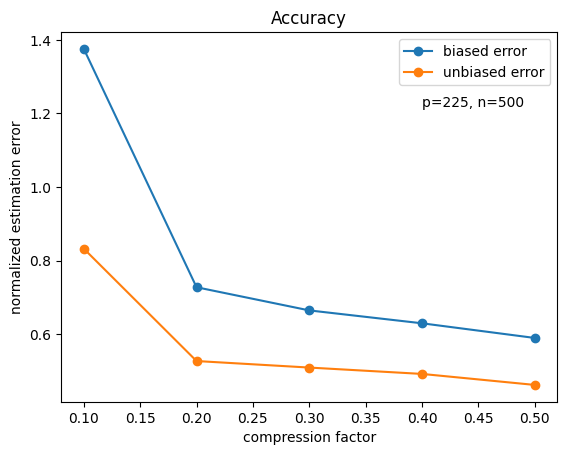

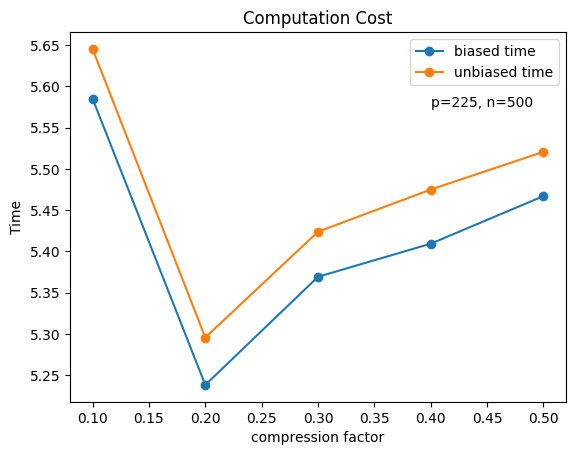

In [8]:
biased_error=[]
unbiased_error=[]
biased_time=[]
unbiased_time=[]
for s in s_values:
  print(f'processing Y = {m/s} value')
  CovMtx = CovarianceMatrix(m, s, X, XXT = XXT)
  biased_error.append(CovMtx.biasedError)
  unbiased_error.append(CovMtx.unbiasedError)
  biased_time.append(CovMtx.biasedTime)
  unbiased_time.append(CovMtx.unbiasedTime)
  del CovMtx

plt.plot(Y,biased_error, marker='o')
plt.plot(Y,unbiased_error, marker='o')
plt.legend(['biased error', 'unbiased error'])
plt.xlabel('compression factor')
plt.ylabel('normalized estimation error')
plt.title('Accuracy')
plt.text(0.83, 0.81, f'p={X.shape[0]}, n={X.shape[1]}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.show()
plt.plot(Y,biased_time, marker='o')
plt.plot(Y,unbiased_time, marker='o')
plt.xlabel('compression factor')
plt.ylabel('Time')
plt.legend(['biased time', 'unbiased time'])
plt.title('Computation Cost')
plt.text(0.83, 0.81, f'p={X.shape[0]}, n={X.shape[1]}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.show()

### Averaged Loop Run

processing loop #0
----------
processing Y = 0.1 value
processing Y = 0.2 value
processing Y = 0.30000000000000004 value
processing Y = 0.4 value
processing Y = 0.5 value
processing loop #1
----------
processing Y = 0.1 value
processing Y = 0.2 value
processing Y = 0.30000000000000004 value
processing Y = 0.4 value
processing Y = 0.5 value
processing loop #2
----------
processing Y = 0.1 value
processing Y = 0.2 value
processing Y = 0.30000000000000004 value
processing Y = 0.4 value
processing Y = 0.5 value
processing loop #3
----------
processing Y = 0.1 value
processing Y = 0.2 value
processing Y = 0.30000000000000004 value
processing Y = 0.4 value
processing Y = 0.5 value
processing loop #4
----------
processing Y = 0.1 value
processing Y = 0.2 value
processing Y = 0.30000000000000004 value
processing Y = 0.4 value
processing Y = 0.5 value
processing loop #5
----------
processing Y = 0.1 value
processing Y = 0.2 value
processing Y = 0.30000000000000004 value
processing Y = 0.4 value

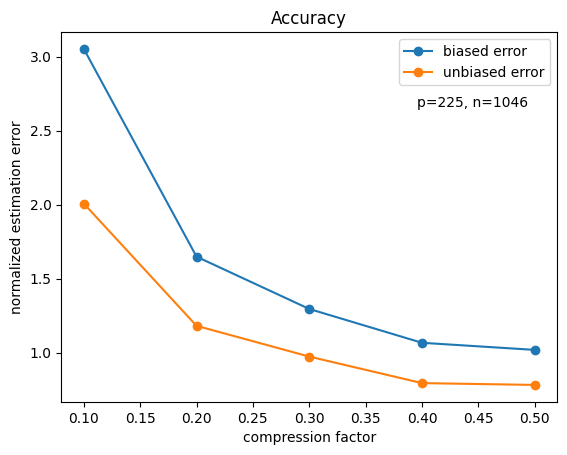

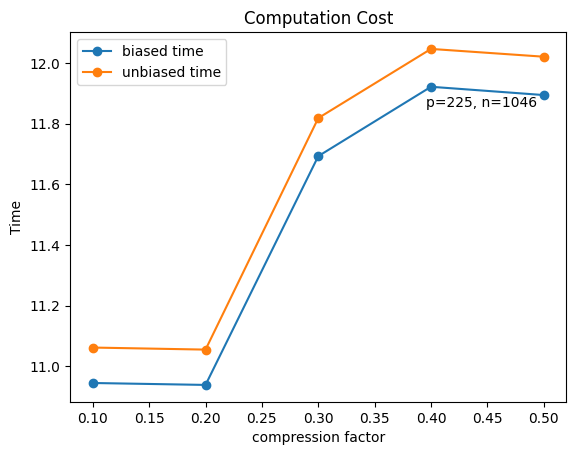

In [9]:
biased_error=np.zeros(Y.shape[0])
unbiased_error=np.zeros(Y.shape[0])
biased_time=np.zeros(Y.shape[0])
unbiased_time=np.zeros(Y.shape[0])
for i in range(10):
    print(f'processing loop #{i}')
    print('-'*10)
    biased_error2=[]
    unbiased_error2=[]
    biased_time2=[]
    unbiased_time2=[]
    for s in s_values:
        print(f'processing Y = {m/s} value')
        CovMtx = CovarianceMatrix(m, s, X, XXT = XXT)
        biased_error2.append(CovMtx.biasedError)
        unbiased_error2.append(CovMtx.unbiasedError)
        biased_time2.append(CovMtx.biasedTime)
        unbiased_time2.append(CovMtx.unbiasedTime)
        del CovMtx
    biased_error = biased_error + np.array(biased_error2)
    unbiased_error = unbiased_error + np.array(unbiased_error2)
    biased_time = biased_time + np.array(biased_time2)
    unbiased_time = unbiased_time + np.array(unbiased_time2)
    
biased_error=biased_error/Y.shape[0]
unbiased_error=unbiased_error/Y.shape[0]
biased_time=biased_time/Y.shape[0]
unbiased_time=unbiased_time/Y.shape[0]

plt.plot(Y,biased_error, marker='o')
plt.plot(Y,unbiased_error, marker='o')
plt.legend(['biased error', 'unbiased error'])
plt.xlabel('compression factor')
plt.ylabel('normalized estimation error')
plt.title('Accuracy')
plt.text(0.83, 0.81, 'p=225, n=1046', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.show()
plt.plot(Y,biased_time, marker='o')
plt.plot(Y,unbiased_time, marker='o')
plt.xlabel('compression factor')
plt.ylabel('Time')
plt.legend(['biased time', 'unbiased time'])
plt.title('Computation Cost')
plt.text(0.83, 0.81, 'p=225, n=1046', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.show()

## Visualization

Verifying the claim in the paper that $\mathbf{R}_i\mathbf{R}_i^T\mathbf{x}_i$ is a close approximation of projection of $\mathbf{x}_i$ onto the column space of $\mathbf{R}_i \in \mathbb{R}^{p\times m}$, we visualize the  $\mathbf{R}_i\mathbf{R}_i^T\mathbf{x}_i$ as images against the original $\mathbf{x}_i$.

### MNIST

Shape of X: (784, 1)
m = 784


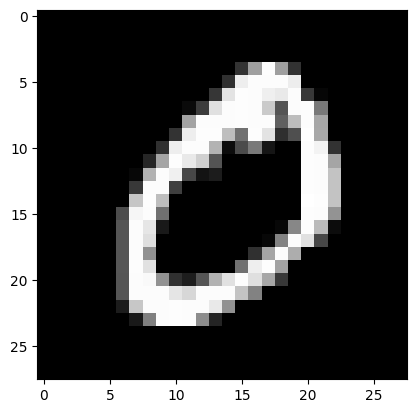

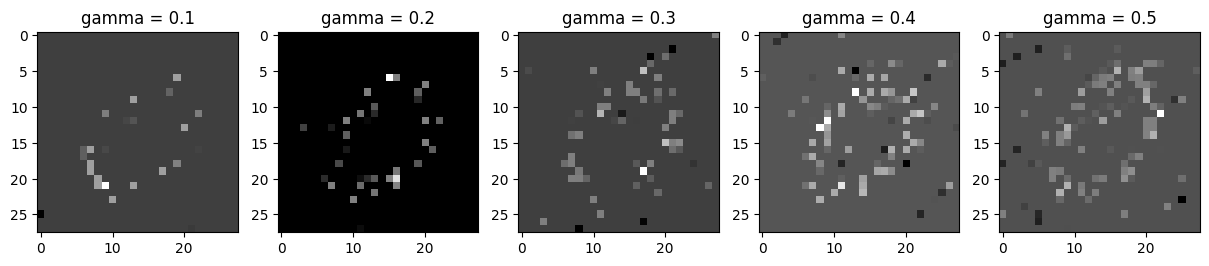

In [10]:
X_mnist = mnist_zeros_loader(n2=1)
plt.imshow(X_mnist.reshape(28,28), cmap='gray')
m_mnist =28*28 #int(np.round(X.shape[0]*0.4)) # m = 0.4 * p
print(f'm = {m_mnist}')
# s_values_mnist = m/Y
XXT_mnist = X_mnist@X_mnist.T
# for s in s_values_mnist:

plt.figure(figsize=(15,10))
for i in range(1,6):
    g = i/10
    s =  m_mnist / g
    MnistCovMtx = CovarianceMatrix(m_mnist, s, X_mnist, XXT = XXT_mnist)
    R0 = MnistCovMtx._R_list[0]
    v = R0@R0.T @ X_mnist
    v = v.reshape(28,28)

    plt.subplot(1,5,i)
    plt.imshow(v, cmap='gray')
    plt.title(f'gamma = {g}')


        


### Traffic 

(1600, 1)
m = 1600


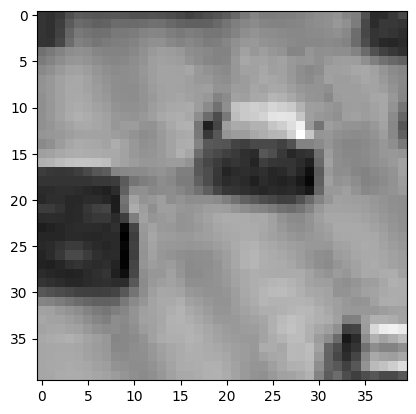

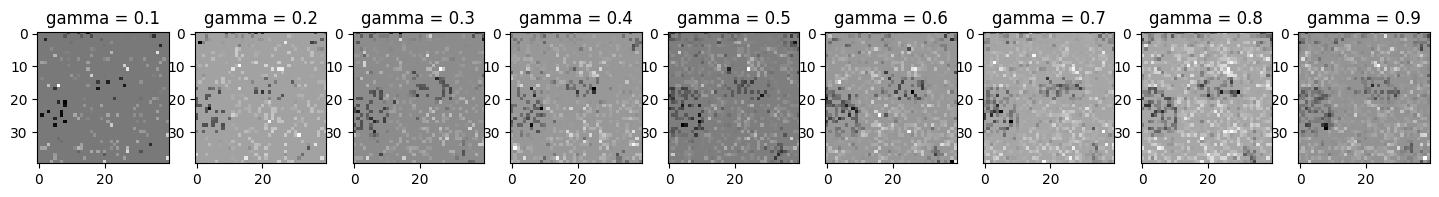

In [11]:
X_traffic = traffic_loader(x1=200,x2=240,y1=100,y2=140, n2=1)
plt.imshow(X_traffic.reshape(40,40), cmap='gray')
m_traffic =40*40 #int(np.round(X.shape[0]*0.4)) # m = 0.4 * p
print(f'm = {m_traffic}')
# s_values_mnist = m/Y
XXT_traffic = X_traffic@X_traffic.T
# for s in s_values_mnist:

plt.figure(figsize=(20, 8))
for i in range(1,10):
    g = i/10
    s =  m_traffic / g
    TrafficCovMtx = CovarianceMatrix(m_traffic, s, X_traffic, XXT = XXT_traffic, runUnbiasedEstimator=False)
    R0 = TrafficCovMtx._R_list[0]
    v = R0@R0.T @ X_traffic
    v = v.reshape(40,40)

    plt.subplot(1,10,i)
    plt.imshow(v, cmap='gray')
    plt.title(f'gamma = {g}')